In [1]:
import pybinding as pb
from BerryEasy import BerryEasy as be
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

# Let us begin with a simple Chern insulator oon a square lattice

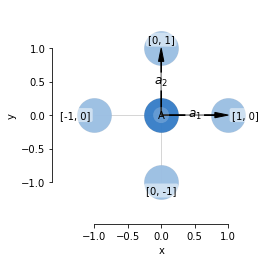

In [2]:
#Define Matrices:
g_1 = np.array([[0,1],[1,0]])
g_2 = np.array([[0,-1j],[1j,0]])
g_3 = np.diag([1,-1])

U=-1.5*g_3
Tx=(1j*g_1+g_3)/2
Ty=(1j*g_2+g_3)/2
#Tz=(1j*g_3+g_5)/2
lat=pb.Lattice(a1=[1,0],a2=[0,1])
lat.add_sublattices(('A', [0,0],U))
lat.add_hoppings(                 
                 ([1,0], 'A', 'A', Tx),
                 ([0,1], 'A', 'A', Ty)
                )
lattice = lat
lattice.plot()
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('Unit_Cell.png')
plt.show()


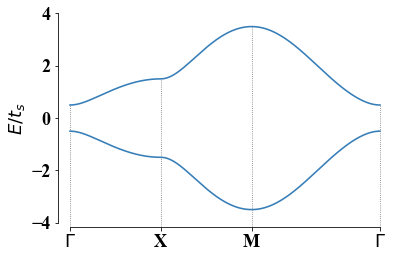

In [3]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 18})
model = pb.Model(lat,
            pb.force_double_precision(),         
            pb.translational_symmetry(a1=True, a2=True, a3=True))
solver = pb.solver.lapack(model)

from math import pi
X = [pi,0,0]
Gamma = [0,0,0]
M= [pi,pi,0]

bands = solver.calc_bands( Gamma, X, M, Gamma,step=0.01)
bands.plot(point_labels=[ r'$\Gamma$', 'X', 'M', r'$\Gamma$'])
plt.ylabel(r'$E/t_{s}$')
plt.xlabel('')
plt.savefig('Chern_Bands.png')

# Let us introduce disorder through pybinding onsite modifier and compute the density of states using the built in KPM solver:

In [8]:
L=100
model = pb.Model(lat,
                 pb.force_double_precision(),
                pb.primitive(L,L),
                pb.translational_symmetry(a1=L, a2=L))

solver=pb.solver.lapack(model)
positions=np.array(getattr(getattr(model, 'system'),'positions'))
BulkAvgDos=[]
for w in tqdm(np.linspace(0.05,3.25,12)):
    avgres=np.zeros(1)
    iteration=0
    while iteration<50:
        pot=[]
        for j in range(np.shape(positions)[1]):
            pot.append(random.gauss(mu=0.0, sigma=w))
        def disorder():
            @pb.onsite_energy_modifier
            def potential(energy, x, y):
                v=0
                for i in range(np.shape(positions)[1]):
                    xpos=positions[0][i]
                    ypos=positions[1][i]
                    v=v+pot[i]*(np.heaviside(-np.absolute(x-xpos),.5))*(np.heaviside(-np.absolute(y-ypos),0.5))
                return energy + v    
            return potential
        model = pb.Model(lat,
            pb.primitive(L,L),
             disorder(),    
            pb.force_double_precision(),
            pb.translational_symmetry(a1=L, a2=L))
        solver = pb.kpm(model)
        ldos = solver.calc_dos([0], broadening=0.01)
        result=getattr(ldos,'data')
        avgres=avgres+result
        if iteration==49:
            BulkAvgDos.append(avgres/100)
        iteration=iteration+1

100%|███████████████████████████████████████████| 12/12 [14:54<00:00, 74.50s/it]


# Plotting the density of states at zero energy we can see that the average bulk gap closes at weak disorder

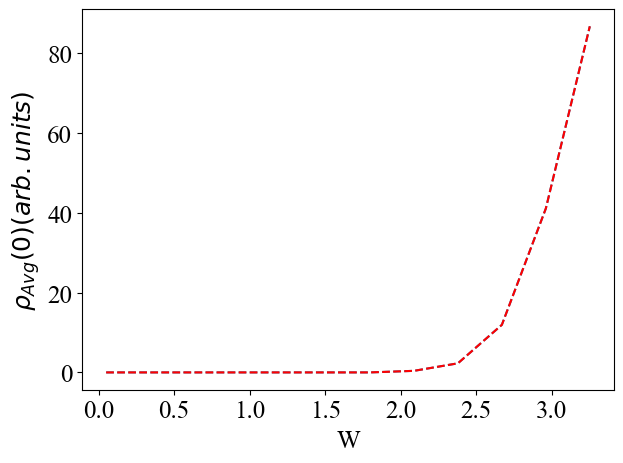

In [13]:
plt.plot(np.linspace(0.05,3.25,12),BulkAvgDos,'--')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})
#plt.plot(SurfTypDos[1],'--',c='red')
plt.plot(np.linspace(0.05,3.25,12),BulkAvgDos,'--',c='red')
plt.xlabel('W')
plt.ylabel(r'$\rho_{Avg}(0) (arb. units)$')
#plt.legend(['Surface','Bulk'])
#plt.title('W=0.5')
plt.tight_layout()
plt.savefig('Avg_DOS_Chern_Disorder.png')

# In order to determine the location at which the bulk mobility gap will close we compute participation ratio of lowest lying states

In [14]:


def probsq(j,df,evecs):
    dim=int(np.shape(evecs)[0])
    prob=[]
    for i in range(0,dim,df):
        pb=0
        for k in range(df):
            pb=pb+np.abs(evecs[i+k][j])**2
        prob.append((pb**2))
    return np.array(prob)
def IPR(df,evecs,nst):
    tot=[]
    for k in range(nst):
        tot.append(np.sum(probsq(k,df,evecs)))
    return np.sum(tot)/nst

In [ ]:
BulkPR3=[]
for w in tqdm(np.linspace(1,30,15)):
    BulkPRL=[]
    for LA in np.linspace(100,200,3):
        L=int(LA)
        model = pb.Model(lat,
                     pb.force_double_precision(),
                    pb.primitive(L,L),
                    pb.translational_symmetry(a1=L, a2=L))
        solver=pb.solver.lapack(model)
        positions=np.array(getattr(getattr(model, 'system'),'positions'))
        avgres=[]
        iteration=0
        while iteration<100:
            pot=[]
            for j in range(np.shape(positions)[1]):
                pot.append(random.gauss(mu=0.0, sigma=w))
            def disorder():
                @pb.onsite_energy_modifier
                def potential(energy, x, y):
                    v=0
                    for i in range(np.shape(positions)[1]):
                        xpos=positions[0][i]
                        ypos=positions[1][i]
                        v=v+pot[i]*(np.heaviside(-np.absolute(x-xpos),.5))*(np.heaviside(-np.absolute(y-ypos),0.5))
                    return energy + v    
                return potential
            model = pb.Model(lat,
                pb.primitive(L,L),
                 disorder(),    
                pb.force_double_precision(),
                pb.translational_symmetry(a1=L, a2=L))
            solver = pb.solver.arpack(model,2)
            evec=solver.eigenvectors
            ipr=IPR(2,evec,2)
            avgres.append(ipr)
            if iteration==99:
                BulkPRL.append(np.mean(avgres)**(-1))
            iteration=iteration+1
    BulkPR3.append(BulkPRL)

In [ ]:
# Plotting the results we find that the bulk mobility gap closes at W~12

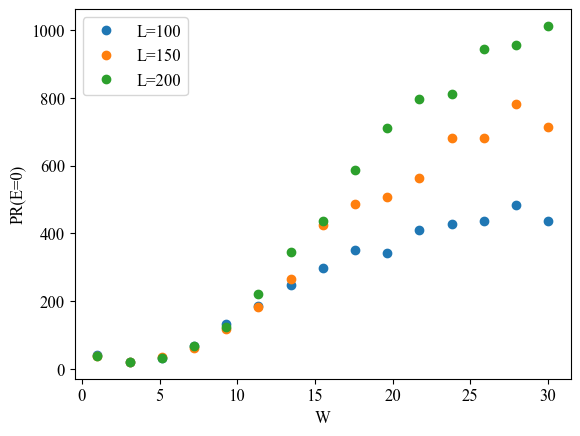

In [38]:
plt.plot(np.linspace(1,30,15),BulkPR3,'o')
plt.ylabel('PR(E=0)')
plt.xlabel('W')
plt.legend(['L=100','L=150','L=200'])
plt.savefig('Chern_Insulator_PR.pdf')
plt.show()

# Now let us investigate the Chern number for the disordered system prior to closure of the bulk mobility gap but after closure of the average gap

In [ ]:
#Note computation time is long for L=41, for quick check i is best to limit the system size but beware of corresponding disorder effects
BulkC1=[]
for w in tqdm([5]):
    BulkCA=[]
    for LA in np.linspace(41,80,1):
        L=int(LA)
        model = pb.Model(lat,
                     pb.force_double_precision(),
                    pb.primitive(L,L),
                    pb.translational_symmetry(a1=L, a2=L))
        solver=pb.solver.lapack(model)
        positions=np.array(getattr(getattr(model, 'system'),'positions'))
        avgres=[]
        iteration=0
        while iteration<1:
            pot=[]
            for j in range(np.shape(positions)[1]):
                pot.append(random.gauss(mu=0.0, sigma=w))
            def disorder():
                @pb.onsite_energy_modifier
                def potential(energy, x, y):
                    v=0
                    for i in range(np.shape(positions)[1]):
                        xpos=positions[0][i]
                        ypos=positions[1][i]
                        v=v+pot[i]*(np.heaviside(-np.absolute(x-xpos),.5))*(np.heaviside(-np.absolute(y-ypos),0.5))
                    return energy + v    
                return potential
            model = pb.Model(lat,
                pb.primitive(L,L),
                 disorder(),    
                pb.force_double_precision(),
                pb.translational_symmetry(a1=L, a2=L))
            solver = pb.solver.lapack(model)
            rvec0=np.diag([2*np.pi/L,2*np.pi/L,2*np.pi/L])
            vec=lambda t1, t2: [t1, t2, 0]
            ds=20
            bnds=range(int(L*L))
            WCCx=be.W(vec,model,bnds,ds,ds,rvec0)
            avgres.append(np.sum(WCCx,1)%(2*np.pi)-np.pi)
            if iteration==0:
                BulkCA.append(avgres)
            iteration=iteration+1
    BulkC1.append(BulkCA)

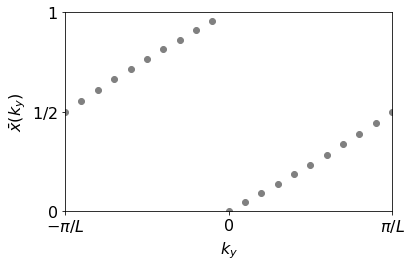

In [6]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 16})
plt.plot(np.sum(WCCx,1)%(2*np.pi)-np.pi,'o', c='gray')
plt.ylim(-pi,pi)
plt.xlim(0,20)
plt.yticks([-pi,0,pi],[r'$0$',r'$1/2$',r'$1$'])
plt.xlabel(r'$k_{y}$')
plt.xticks([0,10,20],[r'$-\pi/L$',r'$0$',r'$\pi/L$'])
plt.ylabel(r'$\bar{x}(k_{y})$')
plt.tight_layout()
#plt.savefig('Disorder_WCC_Chern.png')

# Finally let us plot the disorder configuration

In [ ]:
model.onsite_map.plot(num_periods=0,site_radius=0.4)
plt.colorbar()
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.show()